In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
device = torch.device('cpu')  # Usamos CPU para este ejemplo

In [36]:
# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

In [37]:
def Legendre(x: torch.Tensor, n: int) -> torch.Tensor:

    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for _ in range(2, n):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * _ - 1) / _
        b = (_ - 1) / _

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

class OrthogonalNeuralNetwork(nn.Module):
    
    def __init__(self, n: int, lb: float, ub: float):
        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = torch.nn.Parameter(torch.zeros(n, dtype=torch.float64))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = Legendre(x, self.n)

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.matmul(legendre_polynomials, self.weights) 

In [42]:
lb = 1e-16
ub = 1
x = torch.linspace(lb, ub, 10, dtype=torch.float64, requires_grad=True).to(device)
model = OrthogonalNeuralNetwork(5, lb, ub).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo tiene {num_params} parámetros.')

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(),
                                lr=0.1,
                                max_iter=10_000,
                                max_eval=10_000,
                                tolerance_grad=1e-6,
                                history_size=50,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)
 

# Definir la función de cierre
iter_count=0
def closure():
    global iter_count
    iter_count+=1
    optimizer.zero_grad()
    y_pred = model(x) 
    y_t = x*(x-1)*y_pred
    y_xx = derivative(y_t, x, order=2)
    residuo =  y_xx +  y_t + x
    loss = criterion(residuo,torch.zeros_like(residuo))
    #if iter_count % 100 == 0: 
    #    print(f'iter {iter_count}, loss: {loss.detach().numpy()}')
    loss.backward(retain_graph=True)
    return loss

# Función para entrenar el modelo
def train_model():
    start_time = time.time()
    optimizer.step(closure)
    end_time = time.time()
    y_pred = model(x) 
    y_t = x*(1-x)*y_pred
    y_xx = derivative(y_t, x, order=2)
    residuo =  y_xx +  y_t + x
    loss = criterion(residuo,torch.zeros_like(residuo)) 
    print(f'Final loss: {loss.detach().numpy()}')
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')

# Entrenar el modelo
train_model()

El modelo tiene 5 parámetros.
Final loss: 1.4074073334134645
Tiempo de entrenamiento: 0.26749658584594727 segundos


In [44]:
# Define input x with double precision
x = torch.tensor([0.5191], dtype=torch.float64)

# Ensure prediction y_pred also uses double precision
with torch.no_grad():
    #input_tensor = torch.tensor([1.1320], dtype=torch.float64).to(device)
    y_pred = model(x)

# Perform the computation with double precision
y_pred = x*(1-x)*y_pred  

# Print the result
print(np.round(y_pred.item(), 4))

-0.0705


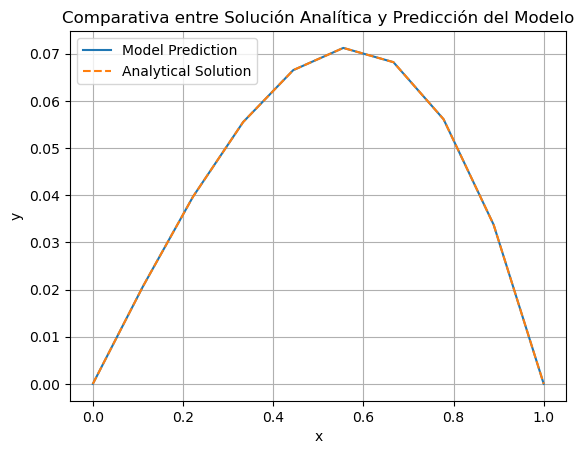

In [45]:
# Define the analytical function
def analytical(x):
    return np.sin(x)/np.sin(1)-x

x_values = np.linspace(lb, ub, 10)

# Calculate y_pred using your model
x_tensor = torch.tensor(x_values, dtype=torch.float64).to(device)
with torch.no_grad():
    y_pred = model(x_tensor)
y_pred = x_tensor*(x_tensor-1) * y_pred

# Convert tensors to numpy arrays for visualization
x_values = x_values
y_pred = y_pred.cpu().detach().numpy()

# Calculate analytical values for comparison
y_analytical = analytical(x_values)

# Plot the results
plt.plot(x_values, y_pred, label='Model Prediction')
plt.plot(x_values, y_analytical, label='Analytical Solution', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparativa entre Solución Analítica y Predicción del Modelo')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


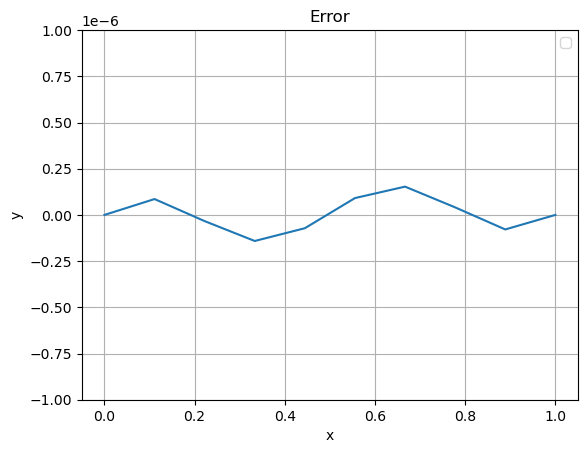

In [46]:
# Plot the results
plt.plot(x_values, y_analytical-y_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-1e-6,1e-6])
plt.title('Error')
plt.legend()
plt.grid(True)
plt.show()